In [16]:
import numpy as np
import dask as da
import fmm.hilbert as hilbert

from fmm.octree import Octree

In [17]:
npoints = 20
maximum_level = 3

rand = np.random.RandomState(0)
sources = rand.rand(npoints, 3)
targets = rand.rand(npoints, 3)

tree = Octree(sources, targets, maximum_level)

In [18]:
@da.delayed
def local_to_multipole(leaf_node_index):
    """Compute multipole expansion from local sources."""
    leaf_id = tree.source_leaf_nodes[leaf_node_index]
    source_indices = tree.sources_by_leafs[
        tree.source_index_ptr[leaf_node_index] : tree.source_index_ptr[leaf_node_index + 1]
    ]
    # Have the source indices. Can now compute the multipole expansion
    pass

@da.delayed
def m2m(node_id, child_expansion):
    """Upward pass of multipole expansion"""
    pass

@da.delayed
def m2l(node_id, interaction_list):
    pass

@da.delayed
def l2l(child, parent_expansion):
    pass

@da.delayed
def l2p(node, expansion):
    pass

@da.delayed
def add_multipole_expansions(expansion1, expansion2):
    pass

@da.delayed
def compute_nearfield(l2p_values):
    pass

def interaction_list_is_empty(key):
    """Return for a key if it has empty interaction list."""
    return np.all(tree.interaction_list[tree.target_node_to_index[key]] == -1)


In [19]:
source_expansions = {}
target_expansions = {}
l2l_expansions = {}
l2p_values = {}

## Compute all upward passes

all_target_nodes = set(tree.non_empty_target_nodes)

# First local to multipole on the leafs
number_of_leafs = len(tree.source_index_ptr) - 1
for index in range(number_of_leafs):
    source_expansions[tree.source_leaf_nodes[index]] = local_to_multipole(index)

#m2m expansions
for key in tree.source_leaf_nodes:
    current = key
    parent = hilbert.get_parent(key)
    while True:
        expansion = m2m(parent, source_expansions[current])
        if not parent in source_expansions:
            source_expansions[parent] = expansion
        else:
            source_expansions[parent] = add_multipole_expansions(source_expansions[parent], expansion)
        if parent == 0:
            break
        else:
            current = parent
            parent = hilbert.get_parent(parent)

#m2l expansions
for index, key in enumerate(tree.non_empty_target_nodes):
    if interaction_list_is_empty(key): continue
    interaction_neighbors = np.extract(
        tree.interaction_list[index] != -1, tree.interaction_list[index]
    )
    expansions = [source_expansions[key] for key in interaction_neighbors]
    target_expansions[key] = m2l(key, expansions)
    
# Now compute the l2l expansions
l2l_queue = [0]
while l2l_queue:
    key = l2l_queue.pop()
    non_empty_children = [child for child in hilbert.get_children(key) if child in all_target_nodes]
    if hilbert.get_level(key) < maximum_level - 1:
        l2l_queue.extend(non_empty_children)
    # I have no expansion. Therefore cannot contribute to l2l of children
    if not key in target_expansions: continue
    for child in non_empty_children:
        if not child in target_expansions:
            target_expansions[child] = l2l(child, target_expansions[key])
        else:
            target_expansions[child] = add_multipole_expansions(target_expansions[child],
                                                               l2l(child, target_expansions[key]))


for key in tree.target_leaf_nodes:
    if key in target_expansions:
        l2p_values[key] = l2p(key, target_expansions[key])
        
result = compute_nearfield(l2p_values)

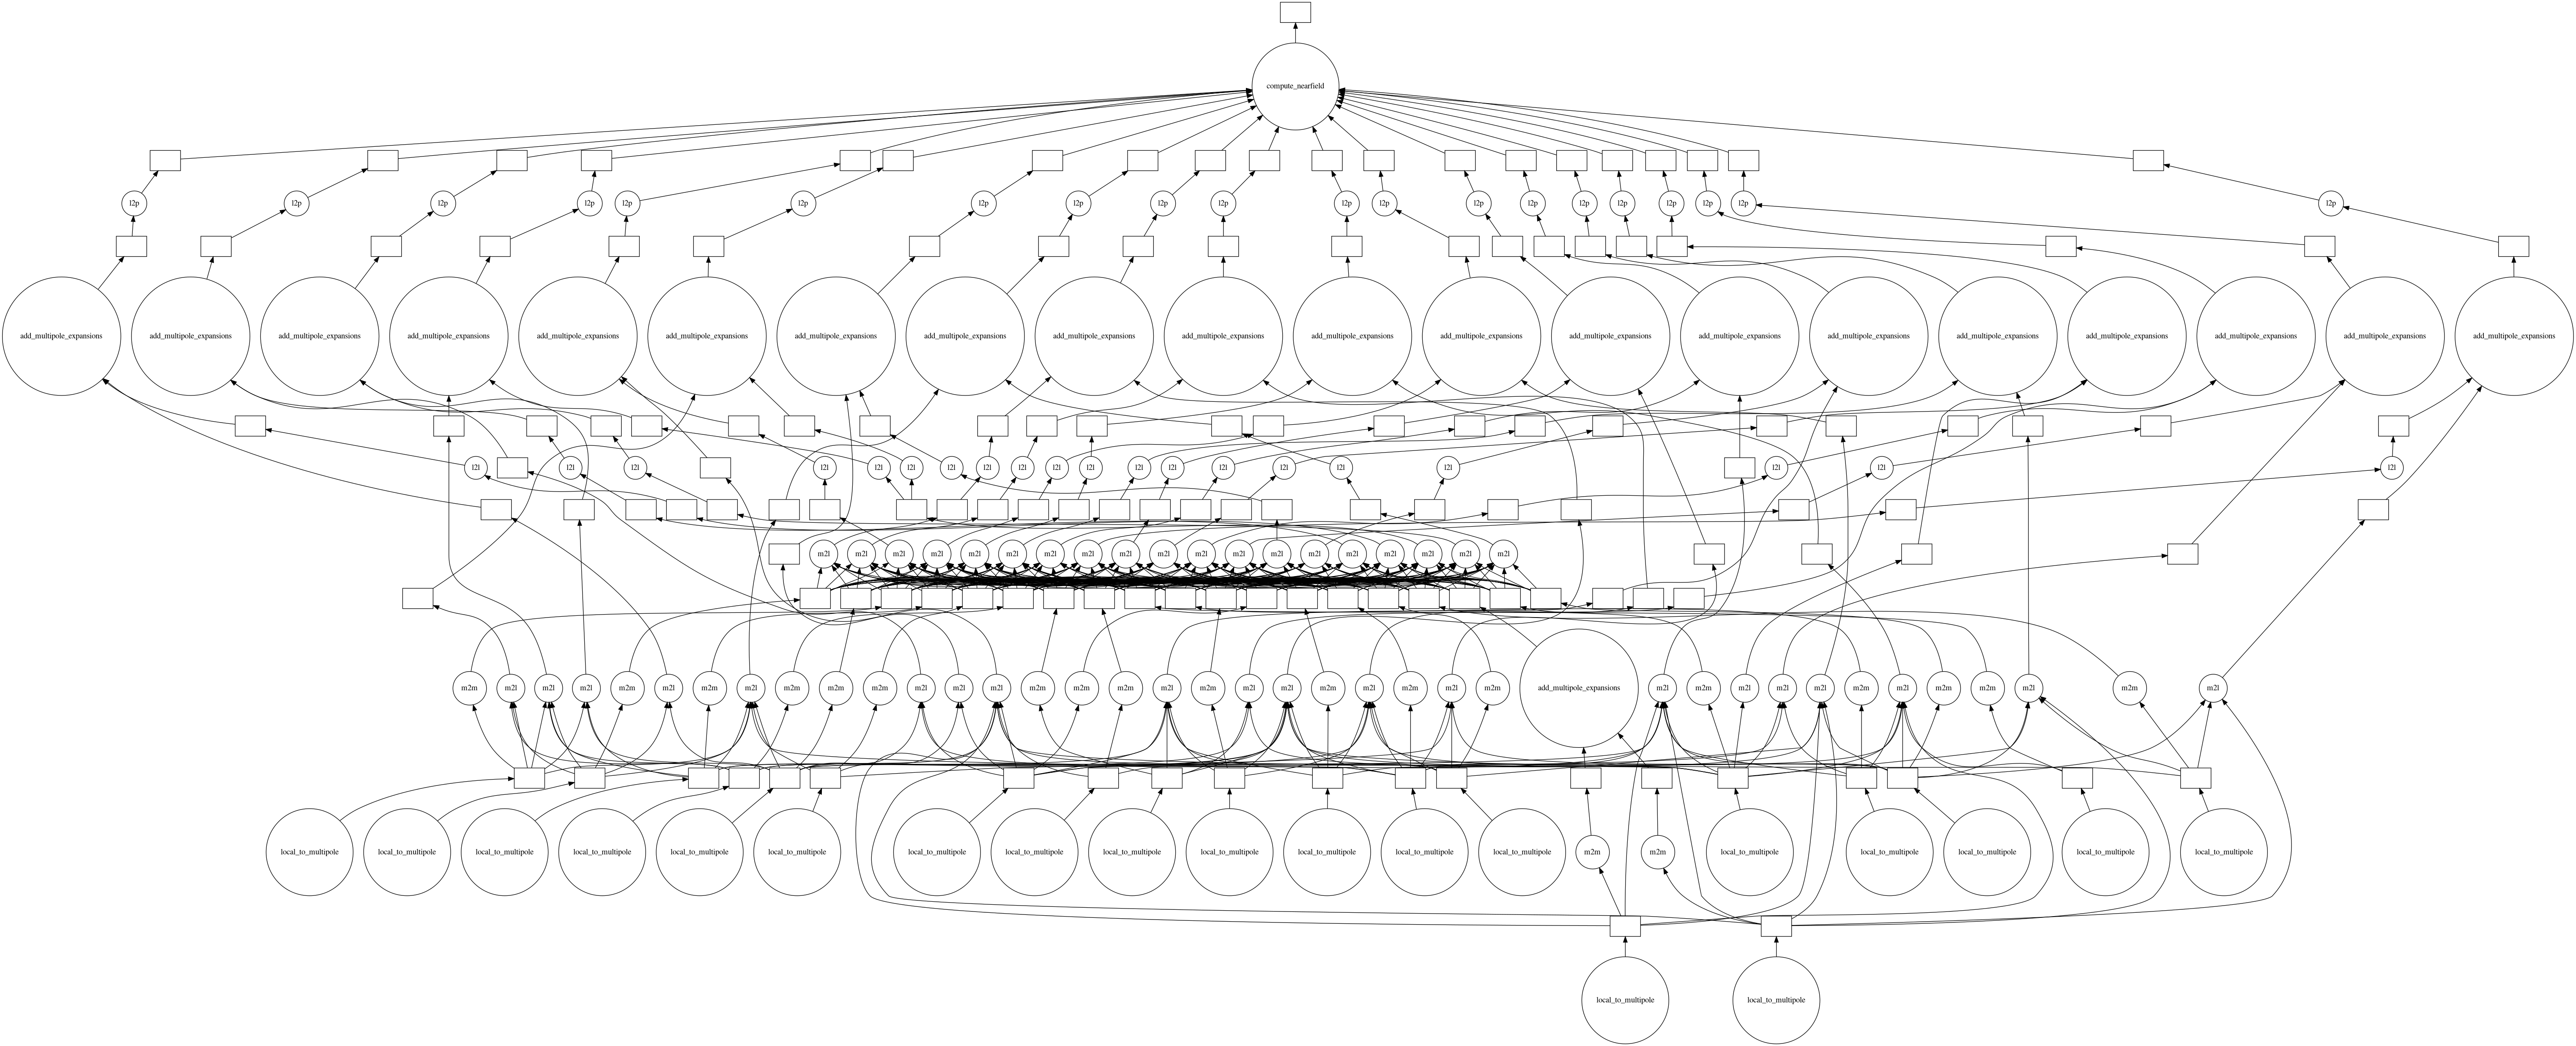

In [20]:
result.visualize()